In [1]:
import numpy as np
from scipy.linalg import eigh
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import silhouette_score
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, random_split
from tqdm.notebook import tqdm, trange
import torch.nn.functional as F
import torch.nn as nn
import torch
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.manifold import TSNE
import os
import faiss

torch.manual_seed(42)

In [2]:
k = os.getenv("K", 4)
NUM_EPOCHS = int(os.getenv("NUM_EPOCHS", 15))

PRF_KEY = int(os.getenv("PRF_KEY", 42))
LABELING = os.getenv("LABELING", "rand_proj")
ROOT_DIR = os.getenv("ROOT_DIR", "..")
ALIGN = bool(int(os.getenv("ALIGN", 1)))
OUTPUT_DIR = os.getenv("OUTPUT_DIR", f"output/k{k}_v1")
ALIGNMENT_MODEL = os.getenv("ALIGNMENT_MODEL", "ridge")

tokenizer_len = 32000


assert ALIGNMENT_MODEL in ["ridge", "distillation"]
assert LABELING in ["kmeans", "rand_proj"]


k = int(k)
print(f"K: {k}, Num epochs: {NUM_EPOCHS}")

K: 4, Num epochs: 15


In [3]:
model_name = "meta-llama/Llama-2-7b-hf"
dataset_name = "Skylion007/openwebtext"
model_suffix = model_name.split("/")[-1]
dataset_suffix = dataset_name.split("/")[-1]
dir = f"{ROOT_DIR}/data/{dataset_suffix}_{model_suffix}"
model_dir = f"{ROOT_DIR}/saved_models/{dataset_suffix}_{model_suffix}"
hidden_states = torch.load(f"{dir}/hidden_states.pt")


hidden_states = hidden_states.float()

/tmp/ipykernel_302659/1536919554.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hidden_states = torch.load(f"{dir}/hidden_states.pt")


In [4]:
def ridge_regression(X, Y, alpha):
    d_in = X.shape[1]
    I = torch.eye(d_in, device=X.device)
    W = torch.linalg.solve(X.T @ X + alpha * I, X.T @ Y)
    return W


def ols(X, Y):
    return torch.linalg.lstsq(X, Y).solution

In [5]:
if ALIGN:
    if ALIGNMENT_MODEL == "ridge":
            W_align = torch.load(f"{model_dir}/align_ridge.pt").cpu().T
    elif ALIGNMENT_MODEL == "distillation":
            W_align = torch.load(f"{model_dir}/align_distillation.pt").cpu().T
else:
    W_align = torch.eye(hidden_states.shape[1], device=hidden_states.device)

/tmp/ipykernel_302659/2508493559.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  W_align = torch.load(f"{model_dir}/align_ridge.pt").cpu().T


In [6]:
def generate_rand_proj_labels(prf_key, k):
    rng = torch.Generator()
    rng.manual_seed(prf_key)
    W_random = torch.randn(
        W_align.shape[1], k, generator=rng)
    print(W_random.shape, W_align.shape)
    W_random = W_align @ W_random
    print(W_random.shape)
    logits = F.linear(hidden_states, W_random.T)
    return logits


def generate_kmeans_labels_new(prf_key, k):
    hidden_states_aligned = torch.matmul(hidden_states, W_align)

    if ALIGN:
        # Normalize for cosine distance
        kmeans_input = torch.nn.functional.normalize(
            hidden_states_aligned, dim=1)
        # Inner product == cosine sim for normed vectors
        index = faiss.IndexFlatIP(kmeans_input.shape[1])
    else:
        kmeans_input = hidden_states_aligned
        index = faiss.IndexFlatL2(kmeans_input.shape[1])  # Euclidean

    # Convert to float32 numpy
    data_np = kmeans_input.cpu().numpy().astype('float32')

    # Build kmeans object
    kmeans = faiss.Clustering(
        data_np.shape[1],
        k
    )
    kmeans.niter = 200
    kmeans.seed = prf_key
    if ALIGN:
        kmeans.spherical = True

    # Train and get labels
    kmeans.train(data_np, index)
    _, labels = index.search(data_np, 1)

    all_labels = torch.tensor(
        labels.squeeze(), device=hidden_states.device, dtype=torch.long)
    return all_labels


def generate_kmeans_labels(prf_key, k):
    kmeans = MiniBatchKMeans(
        n_clusters=k, random_state=prf_key, batch_size=8192*10, max_iter=200)
    hidden_states_aligned = torch.matmul(hidden_states, W_align)
    if ALIGN:
        # Normalize because cosine distance matters for for aligned vectors
        hidden_states_aligned = torch.nn.functional.normalize(
            hidden_states_aligned, dim=1)

    kmeans.fit(hidden_states_aligned.cpu().numpy())
    all_labels = kmeans.labels_
    all_labels = torch.tensor(
        all_labels, device=hidden_states.device, dtype=torch.long)
    return all_labels

In [7]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def compare_label_stability(method, prf_key1, prf_key2):
    labels1 = method(prf_key1, 16).cpu().numpy()
    labels2 = method(prf_key2, 16).cpu().numpy()

    ari = adjusted_rand_score(labels1, labels2)
    nmi = normalized_mutual_info_score(labels1, labels2)

    print(f"{method.__name__} - ARI: {ari:.4f}, NMI: {nmi:.4f}")


In [8]:

# PRF_KEY = PRF_KEY % 2**64
# if LABELING == "kmeans":
#     all_labels = generate_kmeans_labels_new(PRF_KEY, k)
# elif LABELING == "rand_proj":
#     all_labels = generate_rand_proj_labels(PRF_KEY, tokenizer_len)

In [41]:
d = W_align.shape[1]           # Input dimension
V = 32000         # Output dimension
def make_sparse_projection(V, d, num_active=1):
    W = torch.zeros(V, d)
    for i in range(V):
        idx = torch.randperm(d)[:num_active]
        signs = torch.randint(0, 2, (num_active,)).float() * 2 - 1  # ±1
        W[i, idx] = signs
    return W
W = make_sparse_projection(V, d, num_active=3).T

W = W_align @ W
W.shape

torch.Size([4096, 32000])

In [42]:
h_samples = hidden_states[:10]
h_samples.shape
logits = F.linear(h_samples, W.T)
logits.shape

torch.Size([10, 32000])

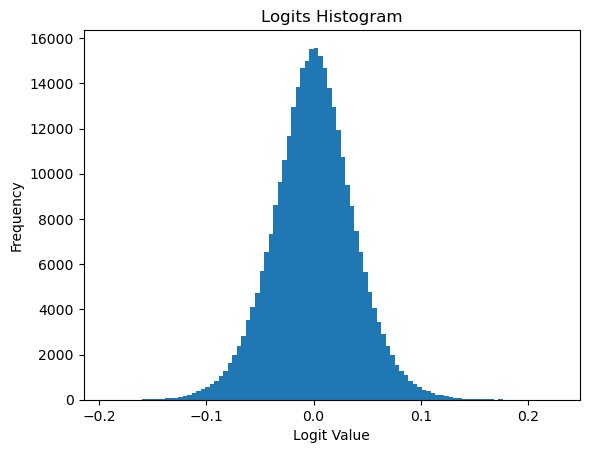

In [43]:

# Plot histogram of logits
plt.hist(logits.flatten().cpu().numpy(), bins=100)
plt.title("Logits Histogram")
plt.xlabel("Logit Value")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Plot counts of each cluster as pie chart
unique, counts = torch.unique(all_labels, return_counts=True)
counts = counts.cpu().numpy()
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=unique.cpu().numpy(), autopct='%1.1f%%')
plt.title("Cluster Distribution")
plt.show()

In [ ]:
class LinearProjectionModel(nn.Module):
    def __init__(self, input_dim, output_dim, projection):
        super(LinearProjectionModel, self).__init__()
        self.register_buffer("projection", projection.T)
        self.linear = nn.Linear(projection.shape[1], output_dim, bias=False, dtype=hidden_states.dtype)

    def forward(self, hidden_states):
        x = F.linear(hidden_states, self.projection)
        return self.linear(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

W_align = W_align.to(device)
# Create a dataset with the labels
dataset = TensorDataset(hidden_states, all_labels)
train_size = int(0.75 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_indices = train_dataset.indices
val_indices = val_dataset.indices
train_hidden_states = hidden_states[train_indices]
train_labels = all_labels[train_indices]

# create a downsampled dataset from the train dataset
train_hidden_states_downsampled = []
train_labels_downsampled = []
for i in range(k):
    class_indices = (train_labels == i).nonzero(as_tuple=True)[0]
    class_data = train_hidden_states[class_indices]
    # Sample min(samples_per_class, available samples)
    sampled_indices = class_indices[torch.randperm(
        len(class_data))[:min(30000, len(class_data))]]
    train_hidden_states_downsampled.append(
        hidden_states[sampled_indices])
    train_labels_downsampled.append(all_labels[sampled_indices])
train_hidden_states_downsampled = torch.cat(
    train_hidden_states_downsampled).to(device)
train_labels_downsampled = torch.cat(
    train_labels_downsampled).to(device)


val_hidden_states = hidden_states[val_indices].to(device)
val_labels = all_labels[val_indices].to(device)


print(f"Train size: {train_size}, Val size: {val_size}")
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=128,
                              shuffle=True, num_workers=1)
val_dataloader = DataLoader(
    val_dataset, batch_size=128, shuffle=False)

In [ ]:

def rescale(final_matrix, X_train_dataset, X_train_labels):
    X_projected = F.linear(X_train_dataset, final_matrix)
    max_values, max_indices = torch.max(X_projected, dim=1)
    cluster_max_means = []
    for i in range(k):
        values = max_values[X_train_labels == i]
        cluster_max_means.append(values.mean())

    cluster_max_means = torch.tensor(
        cluster_max_means, device=final_matrix.device).pow(-1)
    cluster_max_means = torch.diag(cluster_max_means)
    final_matrix = cluster_max_means @ final_matrix
    return final_matrix


def compute_accuracy(final_matrix, X, y_true):
    X_projected = F.linear(X, final_matrix)
    y_pred = torch.argmax(X_projected, dim=1)
    accuracy = (y_pred == y_true).float().mean().item()
    return accuracy


def post_process(weights, projection):
    selector_matrix = weights @ projection.T
    final_matrix = rescale(
        selector_matrix, train_hidden_states_downsampled, train_labels_downsampled)
    train_accuracy = compute_accuracy(
        final_matrix, train_hidden_states_downsampled, train_labels_downsampled)
    val_accuracy = compute_accuracy(
        final_matrix, val_hidden_states, val_labels)
    print(
        f"Train Accuracy: {train_accuracy:.4f} Val Accuracy: {val_accuracy:.4f}")
    return final_matrix

In [ ]:
# Create one hot encoding of train_labels
train_labels_one_hot = torch.zeros(
    train_labels.size(0), k)
train_labels_one_hot.scatter_(1, train_labels.unsqueeze(1), 1)
train_labels_one_hot = train_labels_one_hot.float()


W = ridge_regression(
    train_hidden_states @ W_align.cpu(), train_labels_one_hot, alpha=1e-3)


final_matrix = post_process(W.T.to(device), W_align)

final_matrix = final_matrix.to(device)

Visualize selectors

In [ ]:
X_sample_projected = F.linear(val_hidden_states, final_matrix)

In [ ]:
# Calculate one-hot vectors from val_labels
one_hot_labels = torch.zeros(
    (val_labels.shape[0], k), device=val_labels.device)
one_hot_labels.scatter_(1, val_labels.unsqueeze(1), 1)

# Calculate the L1 loss with X_sample_projected and one_hot_labels
loss = F.l1_loss(X_sample_projected, one_hot_labels)
print(f"Final L1 loss: {loss.item()}")

In [ ]:
rows = (k + 1) // 2  # Ensure enough rows for all classes
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(
    12, 4 * rows), constrained_layout=True)
axes = axes.flatten()  # Flatten in case of a single row
l1_loss = nn.L1Loss()
class_counts = torch.zeros(k)
total_loss = 0
for i in range(k):
    class_indices_1 = (val_labels == i).nonzero(as_tuple=True)[0]
    class_counts[i] = len(class_indices_1)
    class_data = X_sample_projected[class_indices_1].cpu()
    argmax = class_data[:, i]
    rest = torch.cat(
        [class_data[:, :i], class_data[:, i+1:]], dim=1)
    rest = rest.sum(dim=1)

    argmax_loss = l1_loss(argmax, torch.ones_like(argmax))
    rest_loss = l1_loss(rest, torch.zeros_like(rest))
    print(f"Class {i} argmax loss: {argmax_loss}")
    print(f"Class {i} rest loss: {rest_loss}")
    total_loss += argmax_loss + rest_loss
    axes[i].hist(argmax, bins=100, alpha=0.5, label=f'Class {i} top')
    axes[i].hist(rest, bins=100, alpha=0.5, label=f'Class {i} rest')

    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
    axes[i].set_title(f"Values for Class {i}")
    axes[i].legend()

# Hide any unused subplots
for j in range(k, len(axes)):
    fig.delaxes(axes[j])

plt.show()

print(f"Average L1 loss: {total_loss/k}")

In [ ]:
proportions = class_counts / class_counts.sum()
plt.pie(proportions.numpy(), labels=range(k), autopct='%1.1f%%')
plt.title('Cluster Proportions')
plt.show()

In [ ]:
max_values, max_indices = torch.max(X_sample_projected, dim=1)
for i in range(k):
    values = max_values[val_labels == i].cpu()
    print(f"Cluster {i}: {values.mean()}, {values.std()}")
    print(f"Min: {values.min()}, Max: {values.max()}")
    plt.hist(values, bins=50,
             alpha=0.5, label=f'Cluster {i}')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Max Values")
plt.legend()
plt.show()

Save model

In [ ]:
# Make sure the directory exists
output_dir = os.path.join(ROOT_DIR, OUTPUT_DIR)

os.makedirs(output_dir, exist_ok=True)

torch.save(final_matrix.cpu(), f"{output_dir}/final_matrix.pt")